# Application level

In [65]:
dir="C:\\Users\\Post G\\Desktop\\프로젝트\\Galaxy Watch Forensic\\Application level\\Watch 3\\gear_dump (2)\\dump\\20221106160524"
dirobj="C:\\Users\\Post G\\Desktop\\프로젝트\\Galaxy Watch Forensic\\Application level\\Watch 3\\Geardumpparsed"

## Module_log

In [2]:
import pandas as pd
import re
import json

In [3]:
#csc-verification-report: 기기 소프트웨어 및 CSC 코드 확인
CSCV=re.compile(r'CSC Version : ([0-9A-Z]{12})')
CSCC=re.compile(r'Sales code : ([A-Z]{3})')
dirr=dir+"\\module_log\\csc\\csc-default\\output\\csc-verification-report.log"
with open(dirr, 'r') as f:
    k=f.read()
CSC_Version=str(CSCV.findall(k)[0])
Region_code=str(CSCC.findall(k)[0])

with open(dirobj+'\\1_CSCversion.json', 'w') as fp:
    json.dump({'CSC_Version':CSC_Version, 'Region_code':Region_code}, fp)
print({'CSC_Version':CSC_Version, 'Region_code':Region_code})

{'CSC_Version': 'R850OXA1ATF3', 'Region_code': 'KOO'}


In [4]:
#SW_Configuration.xml: 기기 소프트웨어가 릴리즈된 국가 코드(CSC)
SWC=re.compile(r'/([A-Z]{3})/')
dirr=dir+"\\module_log\\csc\\csc-default\\SW_Configuration.xml"
with open(dirr, 'r', encoding="utf-8") as f:
    k=f.read()
SWCall=SWC.findall(k)
print("Available Sales Number : ", len(SWCall))
with open(dirobj+'\\2_CSCCode.json', 'w') as fp:
    json.dump({'Available Sales Code':SWCall}, fp)

Available Sales Number :  79


In [5]:
#vconf: 워치와 연결된 컴패니언의 설정 상태
vconfr=re.compile(r'value = (\d+)')
dirr=dir+"\\module_log\\gps\\vconf"
with open(dirr, 'r') as f:
    k=f.readlines()
dic={}
for t in k:
    print(t[:-1])
    dic[t.split(',')[0]]=vconfr.findall(t.split(',')[1])[0]
with open(dirobj+'\\3_Vconf.json', 'w') as fp:
    json.dump(dic, fp)

memory/location/gps/state, value = 0 (Int32)
memory/location/wps/state, value = 0 (Int32)
memory/location/companion/conn_state, value = 1 (Int32)
memory/location/companion_gps/state, value = 0 (Int32)
memory/location/companion_wps/state, value = 0 (Int32)
db/location/setting/Usemylocation, value = 0 (Int32)
db/location/setting/GpsEnabled, value = 0 (Int32)
db/location/setting/NetworkEnabled, value = 0 (Int32)
db/location/setting/CompanionGpsEnabled, value = 1 (Int32)
db/location/setting/CompanionWpsEnabled, value = 1 (Int32)
db/location/last/wps/LocTimestamp, value = 1667698587 (Int32)
db/location/last/gps/LocTimestamp, value = 1047604725 (Int32)


['dump_gps.log', 'dump_gps.log.0', 'dump_lbs_consumer.log', 'lbs.pmap', 'lbs.pmap.1']


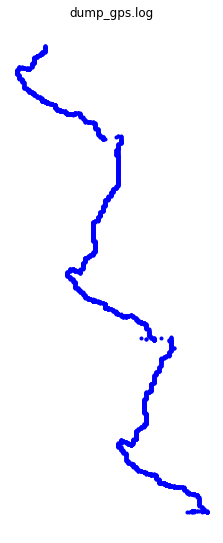

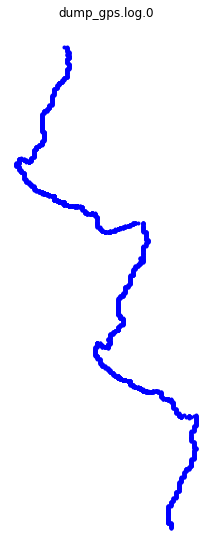

In [66]:
#location.tar.gz: GPS, WPS 작동 및 정지 정보, 변위 시각화
import tempfile
import tarfile
import os
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
AppStartInfoR=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} START .*')
AppStopInfoR=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} STOP .*')
AppGPSInfoR=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} .* pos -> .* \[.*\] - \[.*\]')
AppGPSInfoR2=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} .* pos -> .* \[.*\] - \[([\dx]*) : ([\dx]*)\]')
dirr=dir+"\\module_log\\gps\\location.tar.gz"
with tempfile.TemporaryDirectory() as tmpdir:
    file=tarfile.open(dirr)
    file.extractall(tmpdir)
    file.close()
    print(os.listdir(tmpdir))
    for file in os.listdir(tmpdir):
        time=[]
        x=[]
        y=[]
        x_accum=[]
        y_accum=[]
        if "dump_gps" in file:
            with open(tmpdir+"\\"+file, 'r') as f:
                k=f.read()
                AppStartInfo=AppStartInfoR.findall(k)
                AppStopInfo=AppStopInfoR.findall(k)
                AppGPSInfo=AppGPSInfoR.findall(k)
            Appstartdict={}
            for i in AppStartInfo:
                #10/26 11:17:52.821 START COMPANION-WPS from [lbs-server/get_ref_location]
                strs=i.split('START')
                Appstartdict['Time']=strs[0]
                Appstartdict['Info']=(strs[1]).split('from')[0]
                Appstartdict['Service']=((strs[1]).split('from')[1])[1:-1]
            Appstopdict={}
            for i in AppStopInfo:
                strs=i.split('STOP')
                Appstartdict['Time']=strs[0]
                Appstartdict['Info']=(strs[1]).split('from')[0]
                Appstartdict['Service']=((strs[1]).split('from')[1])[1:-1]
            Sensorinfo=[]
            num=[]
            for i in AppGPSInfo:
                time.append(datetime.datetime.strptime(i[:18], "%m/%d %H:%M:%S.%f"))
                #[3x.4x6x0x : 1x7.x3x5x1]
                #x.append(i[-23:-15])
                #y.append(i[-20:-3])
                #11/06 10:36:28.416 companion-wps pos -> FW : [0] - [3x.4x6x0x : 1x7.x3x5x4]
                x.append(int(i[-16]))
                y.append(int(i[-4]))
                Sensorinfo.append(i.split(' ')[2])
                num.append(i.split(' ')[7][1:-1])
            x_accum.append(x[0])
            y_accum.append(y[0])
            for i in range(len(x)-1):
                x_accum.append(x_accum[i])
                if (x[i+1]-(x_accum[i]%10)+10)%10<=5:
                    while x_accum[i+1]%10!=x[i+1]:
                        x_accum[i+1]=x_accum[i+1]+1
                else:
                    while x_accum[i+1]%10!=x[i+1]:
                        x_accum[i+1]=x_accum[i+1]-1
                y_accum.append(y_accum[i])
                if (y[i+1]-(y_accum[i]%10)+10)%10<=5:
                    while y_accum[i+1]%10!=y[i+1]:
                        y_accum[i+1]=y_accum[i+1]+1
                else:
                    while y_accum[i+1]%10!=y[i+1]:
                        y_accum[i+1]=y_accum[i+1]-1
            for i in range(len(y_accum)):
                y_accum[i]=y_accum[i]*10
                #print(x[i]/10, y[i], x_accum[i]/10, y_accum[i])
            
            df=pd.DataFrame({'Date':[datetime.datetime.strftime(x, "%m.%d %H:%M:%S.%f") for x in time],'Sensorinfo':Sensorinfo, 'num':num, 'X':x, 'Y':y, 'X_accum':x_accum, 'Y_accum':y_accum})
            plt.figure(figsize=((max(y_accum)-min(y_accum))/200,(max(x_accum)-min(x_accum))/200))
            #plt.plot(y_accum, x_accum,color='skyblue',marker='o', markerfacecolor='blue',markersize=6)
            #1틱: 대략 11.1미터, 곧 초속 50미터 이하의 범위에서는 (시속 200km 이하) 유효할 것으로 예상
            plt.axis('off')
            plt.title(file)
            plt.plot(y_accum, x_accum,'bo', markersize=3)
            plt.savefig(dirobj+f'\\4_2_locationIMG_{file}.jpg')
        else:
            pass
dic={'START':Appstartdict, 'STOP':Appstopdict}
with open(dirobj+'\\4_1_locationSTARTSTOP.json', 'w') as fp:
    json.dump(dic, fp)
df.to_json(dirobj+'\\4_2_locationDUMP.json', orient='records')
        
                    
                

11/14 16:48:22.234 START GPS from [3945/com.samsung.shealth-service]
11/14 16:48:30.716 START GPS from [3945/com.samsung.shealth-service]
11/14 16:48:30.837 START GPS from [3945/com.samsung.shealth-service]
11/14 17:11:59.819 START GPS from [3945/com.samsung.shealth-service]
11/14 17:12:02.288 START GPS from [3945/com.samsung.shealth-service]
11/14 17:12:02.420 START GPS from [3945/com.samsung.shealth-service]
11/14 17:33:18.654 START GPS from [3945/com.samsung.shealth-service]
11/14 17:33:24.482 START GPS from [3945/com.samsung.shealth-service]
11/14 17:33:24.615 START GPS from [3945/com.samsung.shealth-service]
11/14 16:48:37.087 STOP GPS from [3945/com.samsung.shealth-service]
11/14 17:10:02.138 STOP GPS from [3945/com.samsung.shealth-service]
11/14 17:10:02.187 STOP GPS from [3945/com.samsung.shealth-service]
11/14 17:12:11.159 STOP GPS from [3945/com.samsung.shealth-service]
11/14 17:33:13.252 STOP GPS from [3945/com.samsung.shealth-service]
11/14 17:33:13.305 STOP GPS from [3945/

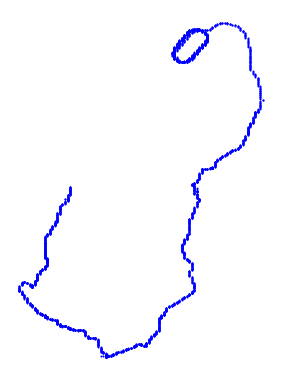

In [7]:
#dump_gps.log: 디버그 레벨에서 위와 같은 방식으로 뽑아올 수 있는 코드
import tempfile
import tarfile
import os
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
AppStartInfoR=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} START .*')
AppStopInfoR=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} STOP .*')
AppGPSInfoR=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} .* pos -> .* \[.*\] - \[.*\]')
AppGPSInfoR2=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} .* pos -> .* \[.*\] - \[([\dx]*) : ([\dx]*)\]')
#dirr=dir+"\\module_log\\gps\\location.tar.gz"
dirr="C:\\Users\\Post G\\Desktop\\loc\\dump_gps.log"
time=[]
x=[]
y=[]
x_accum=[]
y_accum=[]
if 1:
    with open(dirr, 'r') as f:
        k=f.read()
        AppStartInfo=AppStartInfoR.findall(k)
        AppStopInfo=AppStopInfoR.findall(k)
        AppGPSInfo=AppGPSInfoR.findall(k)
    for i in AppStartInfo:
        print(i)
    for i in AppStopInfo:
        print(i)
    for i in AppGPSInfo:
        print(i)
        time.append(datetime.datetime.strptime(i[:18], "%m/%d %H:%M:%S.%f"))
        #[3x.4x6x0x : 1x7.x3x5x1]
        #x.append(i[-23:-15])
        #y.append(i[-20:-3])
        x.append(int(i[-16]))
        y.append(int(i[-4]))
    x_accum.append(x[0])
    y_accum.append(y[0])
    for i in range(len(x)-1):
        x_accum.append(x_accum[i])
        if (x[i+1]-(x_accum[i]%10)+10)%10<=5:
            while x_accum[i+1]%10!=x[i+1]:
                x_accum[i+1]=x_accum[i+1]+1
        else:
            while x_accum[i+1]%10!=x[i+1]:
                x_accum[i+1]=x_accum[i+1]-1
        y_accum.append(y_accum[i])
        if (y[i+1]-(y_accum[i]%10)+10)%10<=5:
            while y_accum[i+1]%10!=y[i+1]:
                y_accum[i+1]=y_accum[i+1]+1
        else:
            while y_accum[i+1]%10!=y[i+1]:
                y_accum[i+1]=y_accum[i+1]-1
    for i in range(len(y_accum)):
        y_accum[i]=y_accum[i]*10
        #print(x[i]/10, y[i], x_accum[i]/10, y_accum[i])
    plt.figure(figsize=((max(y_accum)-min(y_accum))/200,(max(x_accum)-min(x_accum))/200))
    #plt.plot(y_accum, x_accum,color='skyblue',marker='o', markerfacecolor='blue',markersize=6)
    #1틱: 대략 11.1미터, 곧 초속 50미터 이하의 범위에서는 (시속 200km 이하) 유효할 것으로 예상
    plt.axis('off')
    plt.plot(y_accum, x_accum,'bo', markersize=1)
    plt.show()
else:
    pass
        
                    
                

In [8]:
#지리 정보 복구를 위한 엑셀로 내보내기
import pandas as pd
dff=pd.DataFrame({'time': time, 'x': x_accum, 'y': y_accum})
dff.to_excel('좌표.xlsx')

In [9]:
#network\logs\connman.log
#??
#스크립트와 포렌식적 의미를 정리하는 것이 의미가 있음
#칩오프나 이런 부분 한계점이 있었다는 부분

In [10]:
#power/pm_reset_log: 재부팅 로그
dirr=dir+"\\module_log\\power\\pm_reset_log"
with open(dirr, 'r') as f:
    k=f.readlines()
di={}
di['LOGTIME']=k[0][:-1]
lis={}
for i in k[2:]:
    if i=='\n': break
    lis[i[:24]]=i.split(' ')[-1][:-1]
di['LOG']=lis
with open(dirobj+'\\5_pm_reset_log.json', 'w') as fp:
    json.dump(di, fp)

In [53]:
#power/pm_time_history: 시스템 시간대와 시간 정보
systemtimeR=re.compile(r'system time : (\d{4}-\d\d-\d\d \d\d:\d\d:\d\d) \(.*\)')
timezoneR=re.compile(r'timezone\s+: .* \(.*\)')
dirr=dir+"\\module_log\\power\\pm_time_history"
with open(dirr, 'r') as f:
    k=f.read()
txt=k.split('\n\n')
timehistoryheader={}
for l in txt[2].split('\n'):
    timehistoryheader[l.split(':')[0].strip(' ')]=(':'.join( l.split(':')[1:])).strip(' ')
    
timelogheader=re.split(r'\s\s+', txt[3].split('\n')[0])[1:]
df=pd.DataFrame(columns=timelogheader)
dividepoint=[21,28,44,50,65,83,107,129,141]
for line in txt[3].split('\n')[1:]:
    dat=[]
    st=0
    for p in dividepoint:
       dat.append(line[st:p-1].strip()) 
       st=p-1
    dat.append(line[st:].strip())
    df=pd.concat([df, pd.DataFrame([dat], columns=timelogheader)], ignore_index=True)
di={'Info':timehistoryheader}
with open(dirobj+'\\6_1_pm_time_history_LOGINFO.json', 'w') as fp:
    json.dump(di, fp)
df.to_json(dirobj+'\\6_2_pm_time_history_LOG.json', orient='records')


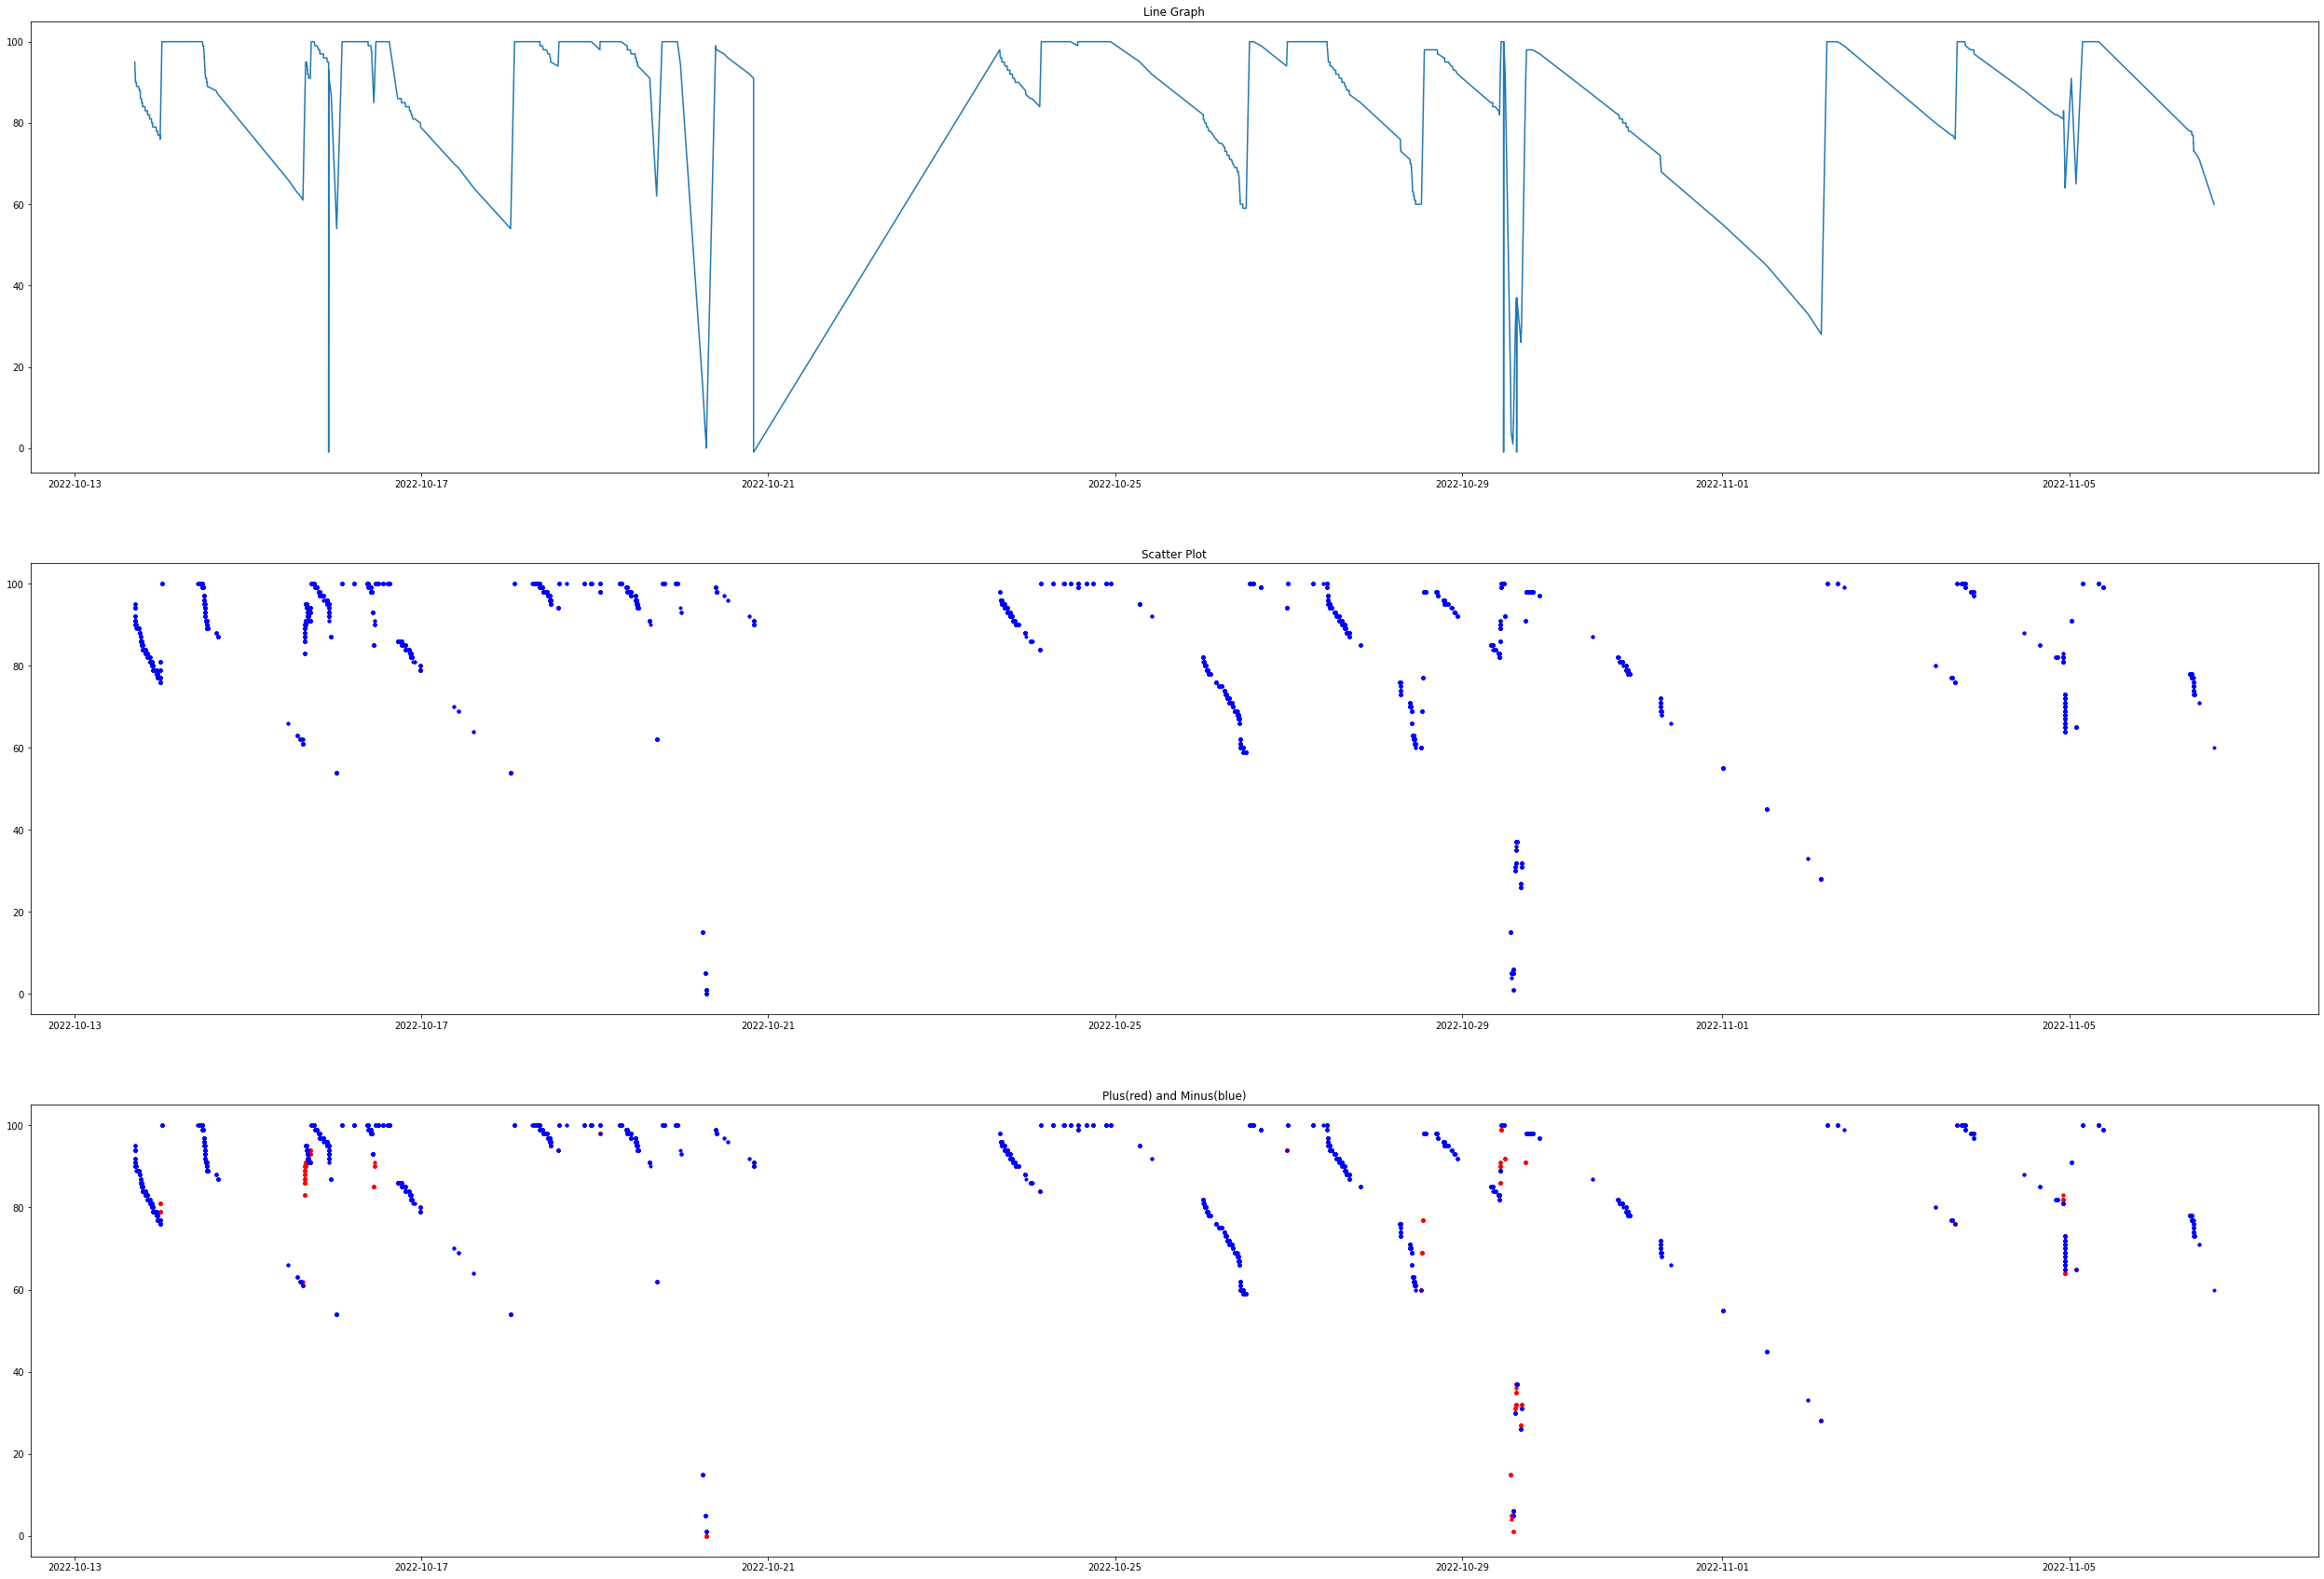

In [52]:
#module_log\battarystat: 배터리 사용 앱과 시간 시각화
import pandas as pd
from matplotlib import pyplot
%matplotlib inline
dirr=dir+"\\module_log\\batterystat221106160538"
batteryR=re.compile(r'\d{6} \d\d:\d\d:\d\d.\d{3}.*\"')
parseR=re.compile(r'\"(.*?)\"')
with open(dirr, 'r') as f:
    k=f.read()
col=['datetime', 'percent', 'status', 'devstatus', 'service', 'fgbg']
df=pd.DataFrame(columns=col)
batteryL=batteryR.findall(k)
Bdate=[]
Bpercent=[]
Bstatus=[]
Devicestatus=[]
deviceApp=[]
fgbg=[]
for _n, i in enumerate(batteryL):
    splitedLog=i.split("(")
    Bdate.append(datetime.datetime.strptime(str(splitedLog[0])[:19], "%y%m%d %H:%M:%S.%f"))
    Bpercent.append(int(list(splitedLog[0].split(" "))[-1]))
    Bstatus.append(str(splitedLog[1])[0])
    Batinfo=parseR.findall(splitedLog[1])
    Devicestatus.append(Batinfo[0])
    if Devicestatus[-1] in ["wkup", "susp", "chg", "dchg"]:
        deviceApp.append(" ")
        fgbg.append(" ")
    else:
        deviceApp.append(str(Batinfo[1]))
        if Devicestatus=="app": fgbg.append(Batinfo[2])
        else: fgbg.append(" ")
'''for _n, i in enumerate(batteryL):
    splitedLog=i.split("(")
    Bdate=datetime.datetime.strptime(str(splitedLog[0])[:19], "%y%m%d %H:%M:%S.%f")
    Bpercent=str(list(splitedLog[0].split(" "))[-1])
    Bstatus=str(splitedLog[1])[0]
    Batinfo=parseR.findall(splitedLog[1])
    Devicestatus=Batinfo[0]
    if Devicestatus in ["wkup","susp","chg", "dchg"]: deviceApp=" "
    else: 
        deviceApp=str(Batinfo[1])
        if Devicestatus=="app": fgbg=str(Batinfo[2])
        else: fgbg=" "
    df=df.append([Bdate, Bpercent, Bstatus, Devicestatus, deviceApp, fgbg], ignore_index=True)
    print(_n, "th line finished")
print(df)'''
df=pd.DataFrame({'Bdate': Bdate, 'Bpercent': Bpercent, 'Bstatus': Bstatus, 'Devstatus': Devicestatus, 'Devapp': deviceApp, 'fgbg': fgbg})
df.to_json(dirobj+'\\7_battrystat.json', orient='records')
df2=df[df['Bpercent']>=0]
plt.figure(figsize=(len(Bdate)/250,(max(Bpercent)-min(Bpercent))*3/10))
plt.subplot(3,1,1)
plt.axis('auto')
plt.title('Line Graph')
plt.plot(Bdate, Bpercent)

plt.subplot(3,1,2)
plt.axis('auto')
plt.title('Scatter Plot')
plt.plot(df2['Bdate'], df2['Bpercent'], 'bo', markersize=3)


plt.subplot(3,1,3)
plt.axis('auto')
plt.title('Plus(red) and Minus(blue)')
dfplus=df2[df2['Bstatus']=="+"]
dfminus=df2[df2['Bstatus']=="-"]
plt.plot(dfplus['Bdate'], dfplus['Bpercent'], 'ro', markersize=3)
plt.plot(dfminus['Bdate'], dfminus['Bpercent'], 'bo', markersize=3)
plt.savefig(dirobj+f'\\7_batterystat.jpg')


In [61]:
#module_log\resourced: 설치된 기본 앱 정보?
dirr=dir+"\\module_log\\resourced_20221106160537.log"
import pandas as pd
with open(dirr, 'r') as f:
    k=f.read()
lins=k.split("inde")
colu=['index','type', 'pkgname', 'appid', 'lru', 'watchdog_exclude', 'runtime_exclude', 'flags', 'state', 'main_pid', 'oomscore', 'memory rss', 'utime', 'stime', 'starttime']
df=pd.DataFrame(columns=colu)
for i in lins[1:]:
    i=i.replace('\n\t', ',')
    t=i.split(',')
    temp=[]
    for k in t:
        temp.append((list(k.split(':'))[1])[1:].strip('\n'))
    df=pd.concat([df, pd.DataFrame([temp], columns=colu)], axis=0, ignore_index=True)
df.to_json(dirobj+'\\8_resourced.json', orient='records')

In [140]:
#makedecodetable, 시저 암호 해독표 만들기: 암호화되어 있던 sand.dump 파일에 대하여 기지 평문 공격으로 key 파악
import re
plaintext="qbuffers journal wizard setup com.samsung com.samsung.tizen.bixby-voice clocksetting viewer weather"
cyphertext="qxtnnbwe dktwjzg uspzwv ebrtl ckh.ezhetjm ckh.ezhetjm.rspbj.xsixo-ykscb cgkcfebrrsjm ysbubw ubzrabw"
dict={}
plaintext=re.sub(r"[^a-zA-Z]", "", plaintext)
cyphertext=re.sub(r"[^a-zA-Z]", "", cyphertext)
for i in range(len(plaintext)):
    try:
        if dict[cyphertext[i]]!=plaintext[i]:
            print('Wrong!!')
    except: pass
    dict[cyphertext[i]]=plaintext[i]
print(dict)

test="Zll jzhb: eabzgra-zgbwr-ysbubw, Wbzekj: Zll cwzea hhcqv xtnnbwe hbhnwbb eoerbhv-dktwjzg Rwsmmbw wbzekj: Skuzsr - Rshberzhl Rwsmmbw ezjzgorscev eoerbhv-tvbyv fukwfbw eabzgra-evf-vzrz-ebwyscb ckh.ezhetjm.ecwbbj-czlrtwb ckh.ezhetjm.x2-ebrtl-uspzwv eabzgra-evf-vzrz-ebwyscb ckh.ezhetjm.cgkcfebrrsjm ckh.ezhetjm.u-cgkcf-ysbubw ckh.ezhetjm.ubzrabw ckh.ezhetjm.u-cgkcf-ysbubw ckh.ezhetjm.cgkcfebrrsjm.wbebr"
result=""
for k in range(len(test)):
    if test[k] in dict.keys():
        result=result+dict[test[k]]
    elif test[k] in ['.', '-', ' ']:
        result=result+test[k]
    else:
        result=result+'?'
print(result)
print(len(dict))
print(sorted(dict.items()))
for item in list(dict.items()):
    dict[item[0].upper()]=item[1].upper()
print(dict)

{'q': 'q', 'x': 'b', 't': 'u', 'n': 'f', 'b': 'e', 'w': 'r', 'e': 's', 'd': 'j', 'k': 'o', 'j': 'n', 'z': 'a', 'g': 'l', 'u': 'w', 's': 'i', 'p': 'z', 'v': 'd', 'r': 't', 'l': 'p', 'c': 'c', 'h': 'm', 'm': 'g', 'i': 'x', 'o': 'y', 'y': 'v', 'f': 'k', 'a': 'h'}
?pp name? shealth-alert-viewer? ?eason? ?pp crash mmcqd buffers memfree systemd-journal ?rigger reason? ?owait - ?imestamp ?rigger sanalyticsd systemd-udevd kworker shealth-sdk-data-service com.samsung.screen-capture com.samsung.b?-setup-wizard shealth-sdk-data-service com.samsung.clocksetting com.samsung.w-clock-viewer com.samsung.weather com.samsung.w-clock-viewer com.samsung.clocksetting.reset
26
[('a', 'h'), ('b', 'e'), ('c', 'c'), ('d', 'j'), ('e', 's'), ('f', 'k'), ('g', 'l'), ('h', 'm'), ('i', 'x'), ('j', 'n'), ('k', 'o'), ('l', 'p'), ('m', 'g'), ('n', 'f'), ('o', 'y'), ('p', 'z'), ('q', 'q'), ('r', 't'), ('s', 'i'), ('t', 'u'), ('u', 'w'), ('v', 'd'), ('w', 'r'), ('x', 'b'), ('y', 'v'), ('z', 'a')]
{'q': 'q', 'x': 'b', 't

In [141]:
#sand 복호화 코드
#암호화가 되어 있는 듯 하나 어떤 식으로 된 건지 알 수 없음
dirr=dir+"\\module_log\\sand\\sand\\opt\\usr\\data\\performance\\sand.dump"
dirr2=dir+"\\module_log\\sand\\sand\\opt\\usr\\data\\performance\\sand2.dump"
with open(dirr, 'r', encoding='utf-8') as f:
    k=f.read()
kn=""
for chr in k:
    if chr in dict.keys():
        kn=kn+dict[chr]
    else: kn=kn+chr
with open(dirr2, 'w', encoding='utf-8') as t:
    t.write(kn)


## Var_log

In [143]:
#var_log\appfw\amd\amd.log: 애플리케이션 사용 기록
dirr=dir+"\\var_log\\appfw\\amd\\amd.log"
with open(dirr, 'r') as f:
    k=f.read()
print(k)

[     0] 2022-11-06 13:38:59 RESUMING         com.samsung.tts-setting-svc                                                                         
[     1] 2022-11-06 13:38:59 SUCCESS: 19545   com.samsung.tts-setting-svc                                                                         
[     2] 2022-11-06 13:49:36 TERMINATED       19545                                                                                               
[     3] 2022-11-06 14:35:27 LAUNCHING        com.samsung.tizen.bixby                                                                             
[     4] 2022-11-06 14:35:27 SUCCESS: 21348   com.samsung.tizen.bixby                                                                             
[     5] 2022-11-06 14:35:27 TERMINATED       18331                                                                                               
[     6] 2022-11-06 15:15:00 LAUNCHING        com.samsung.tizen.samsung-account                                       

In [144]:
#var_log\appfw\app-installers\app-installers.log: 애플리케이션 설치 로그기록
dirr=dir+"\\var_log\\appfw\\app-installers\\app-installers.log"
with open(dirr, 'r') as f:
    k=f.read()
print(k)

[2022-10-16 03:44:25.109 UTC][20738]| INFO    | Configure                 : step_configure.cc:229                : Changed file creation mask from 22 to 22
[2022-10-16 03:44:25.110 UTC][20738]| INFO    | Configure                 : step_configure.cc:202                : AppDir("/opt/usr/globalapps")
[2022-10-16 03:44:25.110 UTC][20738]| INFO    | Configure                 : step_configure.cc:142                : Request Type: Update
[2022-10-16 03:44:25.277 UTC][20738]| INFO    | Unzip                     : step_unzip.cc:106                    : "/opt/usr/home/owner/apps_rw/com.samsung.w-manager-service/data/tizenapp_1665891859236_samsungapps-000004467524-464471-100000017.wgt" was successfully unzipped into "/opt/usr/share/package-unpacked/unpack-692a86"
[2022-10-16 03:44:25.278 UTC][20738]| INFO    | ParseManifest             : step_parse_manifest.cc:1345          : key: accessory-services-location value: /res/xml/accessoryservices.xml
[2022-10-16 03:44:25.279 UTC][20738]| INFO    | P

In [145]:
#var_log\appfw\app-installers\installation-history.log: 애플리케이션 설치 로그기록
dirr=dir+"\\var_log\\appfw\\app-installers\\installation-history.log"
with open(dirr, 'r') as f:
    k=f.read()
print(k)

[2020-06-03 13:40:32.812 UTC][10541]pkgid:com.samsung.watchface|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:40:40.871 UTC][10577]pkgid:com.samsung.sdbd-syspopup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:40:50.953 UTC][10586]pkgid:net.wc-popup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:00.202 UTC][10600]pkgid:org.tizen.aurum-bootstrap|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:08.063 UTC][10623]pkgid:nfc-manager|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:18.102 UTC][10636]pkgid:net.wc-syspopup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:26.055 UTC][10660]pkgid:org.tizen.askuser-popup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:35.836 UTC][10724]pkgid:com.samsung.bt-syspopup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:47.521 UTC][10738]pkgid:com.samsung.w-input-selector|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:55.602 UTC][10752]pkgid:org.tizen.dpm-syspopup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:

In [146]:
#var_log\ghost\boot: 부팅한 횟수
dirr=dir+"\\var_log\\ghost\\boot\\bootcount"
with open(dirr, 'r') as f:
    k=f.read()
print(k)

8



In [147]:
#var_log\pm_state.log: 물리 버튼/LCD ON 기록
dirr=dir+"\\var_log\\pm_state.log"
with open(dirr, 'r') as f:
    k=f.read()
print(k)


pm_state_log now-time : 1667718337(s) Sun Nov  6 16:05:37 2022

pm_status_flag: 0
screen lock status : 0

Timeout Info: Run[14500ms] Dims] Offs]
Tran. Locked : - - S_LCDOFF
Current State: S_LCDOFF
Current Lock Conditions: 
 1: [S_LCDOFF] locked by pid 100005 /usr/bin/deviced Sun Nov  6 16:05:24 2022
current time : Sun Nov  6 16:05:37 2022
[      hash  state]  count      last locktime             last unlocktime         time(s)    process name
[3730410687 LCDOFF]    556                            Sun Nov  6 16:05:24 2022         21    /usr/bin/alarm-server
[3730446434 LCDOFF]    708                            Sun Nov  6 16:05:24 2022        122    /usr/apps/com.samsung.w-manager-service/bin/w-manager-service
[3730441284 LCDOFF]    875                            Sun Nov  6 16:05:23 2022       1485    /usr/bin/sapd
[2844363992 LCDOFF]      1                            Sun Nov  6 16:05:19 2022          1    /usr/apps/com.samsung.update-service/bin/com.samsung.update-service
[3626677427 LC

In [148]:
#dump_systemstate: 로그 종합판?
dirr=dir+"\\dump_systemstate_20221106160524.log"
with open(dirr, 'r', encoding='ISO-8859-1') as f:
    k=f.read()
print(k)

dump_systemstate: 2022-11-06 16:05:25+0900

==== Binary version (/etc/info.ini)
[Version]
Model=SM-R850;
Build=R850XXU1ATF3;
Release=R850XXU1ATF3;
[Build]
Type=user;
Date=20200603_141529;
Time=14:15:29;
Variant=NONE;
ID=R850XXU1ATF3;

==== Tizen version (/etc/tizen-release)
Tizen5/Unified 5.5.0 (arm)
VERSION = 5.5.0
CODENAME = Next
BUILD_ID=PLATFORM_PrdUsrR850XX_20200603.003

==== Kernel version (/proc/version)
Linux version 4.9.59 (abuild@SWDG0013) (gcc version 6.2.1 20161213 (Linaro GCC Snapshot 6.2-2016.12) ) #1-Tizen SMP PREEMPT Wed Jun 3 11:47:40 UTC 2020

==== Boot arguments (/proc/cmdline)
 console=ram loglevel=4 bootmode=ramdisk root=/dev/ram0 rw model=SM-R850 boot_ver=R850XXU1ATF3 hw_rev=08 sec_debug.enable=0 sec_debug.enable_user=0 tizenboot.sec_atd.tty=/dev/ttySAC0 tizenboot.emmc_checksum=0 tizenboot.dram_info=01,07,01,1G tizenboot.log=0x9b010000,0x200000,0x0,0xa89 tizenboot.boottime=2207ms tizenboot.sales_code=KOO warrantybit=0 sec_debug.bin=N lcdtype=0x404583 ess_setup=0x9

# Debug level

In [149]:
dir="C:\\Users\\Post G\\Desktop\\프로젝트\\Galaxy Watch Forensic\\Debug level\\rootoff"

In [150]:
#Smartwatch information WearableStatus.xml, 기기 정보 및 깔려있는 앱 등
import xml.etree.ElementTree as ET
import pandas as pd
dirr=dir+"\\home\\owner\\apps_rw\\com.samsung.w-manager-service\\data\\WearableStatus.xml"
with open(dirr, 'r', encoding='utf-8') as f:
    etree=ET.parse(f)
root=etree.getroot()
dict={}
for child in root[0]:
    if child.text== "\n   ":
        for k in child:
            pass
    elif child.text not in ["", "None", None, "\n   "]:
        dict[child.tag]=child.text
    else: pass
print(dict)

{'deviceID': '34:82:C5:47:82:50', 'deviceName': 'Samsung Gear C', 'devicePlatform': 'Tizen', 'devicePlatformVersion': '5.5.0.0', 'deviceType': 'GearC', 'modelNumber': 'SM-R850', 'swVersion': 'R850XXU1ATF3', 'salesCode': 'KOO', 'countryCode': 'KR', 'serialNumber': 'RFAN93PQTQF'}


In [151]:
#Smartwatch information HostStatus.xml, 페어링된 기기 정보
import xml.etree.ElementTree as ET
import pandas as pd
dirr=dir+"\\home\\owner\\apps_rw\\com.samsung.w-manager-service\\data\\Hoststatus.xml"
with open(dirr, 'r', encoding='utf-8') as f:
    etree=ET.parse(f)
root=etree.getroot()
dict={}
for child in root[0]:
    if child.text== "\n   ":
        for k in child:
            pass
    elif child.text not in ["", "None", None, "\n   "]:
        dict[child.tag]=child.text
    else: pass
print(dict)

{'deviceID': 'A4:6C:F1:D6:BC:9E', 'deviceName': 'Galaxy A8 (2018)', 'devicePlatform': 'android', 'devicePlatformVersion': '9', 'deviceType': 'Host', 'modelNumber': 'SM-A530N', 'swVersion': 'PPR1.180610.011.A530NKSU9CUL1', 'salesCode': 'SKC', 'countryCode': 'KR', 'MCC': '450', 'MNC': '05', 'SDKVersion': '28', 'Resolution': '1080x2220', 'deviceFeature': '\n'}


In [152]:
#Smartwatch information wappStatus.xml, 설치된 애플리케이션 리스트
import xml.etree.ElementTree as ET
import pandas as pd
dirr=dir+"\\home\\owner\\apps_rw\\com.samsung.w-manager-service\\data\\wapplist.xml"
with open(dirr, 'r', encoding='utf-8') as f:
    etree=ET.parse(f)
root=etree.getroot()
dict={}
for child in root[0]:
    if child.text== "\n   ":
        for k in child:
            pass
    elif child.text not in ["", "None", None, "\n   "]:
        dict[child.tag]=child.text
    else: pass
print(dict)

{'AppName': 'Galaxy Store', 'PackageName': 'com.samsung.gearstore', 'ClassName': 'com.samsung.gearstore', 'Version': '5.0.28', 'ImageFileName': 'com.samsung.gearstore.png', 'SettingFileName': 'null', 'PreLoad': 'true', 'AppCategory': 'WATCH_APP', 'IsAppWidget': 'false', 'PushPrivilege': 'false', 'NotiPrivilege': 'true', 'IsRemovable': 'false', 'NoDisplay': 'false', 'Group': 'null'}


In [153]:
#Smartwatch information .account.db 계정 정보
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\dbspace\\5001\\.account.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master;')
tablename=cur.fetchall()
df=pd.read_sql(f'select * from {tablename[0][0]};', con=con)
df

_id             user_name         email_address          display_name  \
0    1  iwatchu745@gmail.com  iwatchu745@gmail.com  iwatchu745@gmail.com   

  icon_path source                       package_name access_token  \
0      None   None  com.samsung.tizen.samsung-account         None   

  domain_name  auth_type  ...  txt_custom0  txt_custom1 txt_custom2  \
0        None          0  ...         None         None        None   

  txt_custom3 txt_custom4 int_custom0 int_custom1  int_custom2  int_custom3  \
0        None        None           0           0            0            0   

   int_custom4  
0            0  

[1 rows x 22 columns]

In [154]:
#Smartwatch information .CompanionInfo.db 연결된 기기 정보
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\usr\\dbspace\\.CompanionInfo.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master;')
tablename=cur.fetchall()
df=pd.read_sql(f'select * from {tablename[0][0]};', con=con)
df

key                          value
0                 device_id              A4:6C:F1:D6:BC:9E
1         device_model_name               Galaxy A8 (2018)
2       device_model_number                       SM-A530N
3       device_plaform_type                        android
4   device_platform_version                              9
5     device_binary_version  PPR1.180610.011.A530NKSU9CUL1
6       device_manufacturer                        samsung
7                sales_code                            SKC
8              country_code                             KR
9                   sim_mcc                            450
10                  sim_mnc                             05
11    sim_subscriber_number                    01021453210

In [155]:
#Smartwatch information ..resourced-heart-default.db 배터리 정보
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\usr\\dbspace\\.resourced-heart-default.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master;')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[2][0]};', con=con)
df

[('abnormal',), ('sqlite_autoindex_abnormal_1',), ('battery',), ('sqlite_autoindex_battery_1',)]


appid             pkgid        time  \
0    org.tizen.system.battery.capacity  org.tizen.system  1665647030   
1    org.tizen.system.battery.capacity  org.tizen.system  1665647217   
2    org.tizen.system.battery.capacity  org.tizen.system  1665647337   
3    org.tizen.system.battery.capacity  org.tizen.system  1665647487   
4    org.tizen.system.battery.capacity  org.tizen.system  1665647638   
..                                 ...               ...         ...   
390  org.tizen.system.battery.capacity  org.tizen.system  1666164305   
391  org.tizen.system.battery.capacity  org.tizen.system  1666164516   
392  org.tizen.system.battery.capacity  org.tizen.system  1666164696   
393  org.tizen.system.battery.capacity  org.tizen.system  1666164846   
394  org.tizen.system.battery.capacity  org.tizen.system  1666164996   

                data   idx  
0     94 1 46 0 0 1      0  
1    93 1 187 0 0 1      1  
2    92 1 120 0 0 1      2  
3    91 1 150 0 0 1      3  
4    90 1 151 0 0 1      4  
..               ...   ...  
390  76 1 210 0 0 1   5898  
391  75 1 210 0 0 1   5934  
392  74 1 180 0 0 1   5935  
393  73 1 150 0 0 1   5936  
394  72 1 150 0 0 1   5937  

[395 rows x 5 columns]

In [156]:
#Smartwatch information ..wnoti-service.db 알림 정보
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\usr\\dbspace\\.wnoti-service.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master;')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[2][0]};', con=con)
df

[('temp_log',), ('sqlite_sequence',), ('application',), ('asset',), ('data',), ('alert_list',), ('cache_action',), ('extra_data',), ('wnoti_idx1',), ('wnoti_idx2',), ('wnoti_idx3',), ('wnoti_idx4',), ('wnoti_idx5',), ('wnoti_idx6',), ('wnoti_idx7',), ('timeline1',), ('timeline2',), ('timeline3',)]


id  application_id                                           panel_id  \
0    1           -1000                                 com.apple.AppStore   
1    2             -51                                                  3   
2    3             -53                                                  2   
3    4           -1003                                        Call_others   
4    5             101                                            message   
5    6              -1                                               cmas   
6    7              -4                                    delivery_report   
7    8             -12                                           temp_mms   
8    9           -1008                           com.samsung.gearstoresvc   
9   10           -1009       com.samsung.message.consumer@CHANNEL@message   
10  11           -1010  com.samsung.shealth.notification-service.EXERC...   
11  12           -1011    com.samsung.shealth.notification-service.STEP_3   
12  13             100                                        missed_call   
13  14           -1013  com.samsung.shealth.notification-service.DAILY...   
14  15           -1014                          com.samsung.weather-agent   

    time_stamp  last_receive_time  display_count  status h_source  app_source  \
0          0.0                0.0            NaN       4     None           2   
1          0.0                0.0            NaN       4     None           2   
2          0.0                0.0            NaN       4     None           2   
3          0.0                0.0            NaN       4     None           2   
4          NaN                NaN            NaN       4     None           1   
5          NaN                NaN            0.0       4     None           1   
6          NaN                NaN            0.0       4     None           1   
7          NaN                NaN            0.0       4     None           1   
8          NaN                NaN            3.0       4     None           1   
9          NaN                NaN            2.0       4     None           1   
10         NaN                NaN            1.0       4     None           1   
11         NaN                NaN            1.0       4     None           1   
12         NaN                NaN            0.0       4     None           1   
13         NaN                NaN            1.0       4     None           1   
14         NaN                NaN            NaN       4     None           1   

   is_clear  ...              package_name label bg_image_path bind_static  \
0      None  ...        com.apple.AppStore  None          None        None   
1      None  ...     com.apple.mobilephone  None          None        None   
2      None  ...     com.apple.mobilephone  None          None        None   
3      None  ...     com.apple.mobilephone  None          None        None   
4      None  ...       com.samsung.message  None          None        None   
5      None  ...       com.samsung.message  None          None        None   
6      None  ...       com.samsung.message  None          None        None   
7      None  ...       com.samsung.message  None          None        None   
8      None  ...     com.samsung.gearstore  None          None        None   
9      None  ...       com.samsung.message  None          None        None   
10     None  ...  com.samsung.shealth_gear  None          None        None   
11     None  ...  com.samsung.shealth_gear  None          None        None   
12     None  ...                      None  None          None        None   
13     None  ...  com.samsung.shealth_gear  None          None        None   
14     None  ...       com.samsung.weather  None          None        None   

   icon_color data1 data2 data3 data4  \
0           0  None   0.0     0  None   
1           0  None   1.0     0  None   
2           0  None   1.0     0  None   
3           0  None   1.0     0  None   
4           0  None 

In [157]:
#Smartwatch information ..wnoti-service.db 알림 정보
#\home\owner\apps_rw\com.samsung.tizen.samsung-account\data
#https://docs.tizen.org/application/native/guides/data/sql/
import sqlite3
import pandas as pd
dirr=dir+"\\home\\owner\\apps_rw\\com.samsung.tizen.samsung-account\\data\\samsungaccount.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master;')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[4][0]};', con=con)
df

[('USERINFO0',), ('sqlite_autoindex_USERINFO0_1',), ('SERVICEAPP0',), ('sqlite_autoindex_SERVICEAPP0_1',), ('USERPROFILE0',), ('sqlite_autoindex_USERPROFILE0_1',)]


KEY  \
0                     names:givenName   
1   phoneNumbers:metadata:source:type   
2        names_2:metadata:source:type   
3      birthdays:metadata:source:type   
4          names:metadata:source:type   
5                    phoneNumbers:key   
6                   phoneNumbers:type   
7                  birthdays:date:day   
8                   names_2:givenName   
9                  phoneNumbers:value   
10                 names_2:familyName   
11                birthdays:date:year   
12                               etag   
13               birthdays:date:month   
14                          nicknames   
15                            genders   
16                       webAddresses   
17                             userId   
18                             photos   
19                      organizations   
20                     emailAddresses   
21                              notes   
22                             events   
23                  messengerAccounts   
24                     statusMessages   
25                       phoneNumbers   
26                          birthdays   
27                            healths   
28                              names   

                                                VALUE EXTRA1 EXTRA2 EXTRA3  
0                            NyGQNVPEBsUdFBYbyQPW5Q==   None   None   None  
1                            t1NSlEU8pcPkju+KMsdORA==   None   None   None  
2                            Lf6pVeuVviPu4XLydvjHOQ==   None   None   None  
3                            Lf6pVeuVviPu4XLydvjHOQ==   None   None   None  
4                            t1NSlEU8pcPkju+KMsdORA==   None   None   None  
5   DX5vX8FKMjfm3zrRfYT7EzwNrRu4DoQtjk+q1HYqV3SO7K...   None   None   None  
6                            Rt5yEelHknynBkBnabvX9A==   None   None   None  
7                            s9W3yf/OEAaJxWMBYnWuHg==   None   None   None  
8                            NyGQNVPEBsUdFBYbyQPW5Q==   None   None   None  
9                            h4wSNZ+BTQKugmrgOVtcVw==   None   None   None  
10                           gGuixnoUHF7zFLQwm7+R2w==   None   None   None  
11                           afrPebszzt1mbYCVqK18AA==   None   None   None  
12       Qn0kJb4/nieXG4MMZHeCKc72oheNniiQiyFlueccuyc=   None   None   None  
13                           s9W3yf/OEAaJxWMBYnWuHg==   None   None   None  
14                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
15                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
16                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
17                           h2QzPiJ3jXu2DDD+I6OGSw==   None   None   None  
18                           Fa4G958FrpMHsWCHlUHjTA==   None   None   None  
19                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
20                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
21                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
22                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
23                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
24                           z4oD5lUlj308uAS4MsZJJA==   None   None   None  
25                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
26                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
27                           cQU8fnN1nBX9mbYL6ZyL/w==   None   None   None  
28                           z4oD5lUlj308uAS4MsZJJA==   None   None   None

In [158]:
#Smartwatch information .contacts-svc.db 알림 정보
import sqlite3
import pandas as pd
dirr=dir+"\\home\\owner\\.applications\\dbspace\\privacy\\.contacts-svc.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[2][0]};', con=con)
df

[('persons',), ('sqlite_sequence',), ('addressbooks',), ('contacts',), ('contact_deleteds',), ('cts_version',), ('sdn',), ('data',), ('groups',), ('group_deleteds',), ('group_relations',), ('speeddials',), ('favorites',), ('sim_info',), ('phonelogs',), ('phonelog_accumulation',), ('phonelog_stat_with_slot_no',), ('contact_stat',), ('contact_stat2',), ('activities',), ('activity_photos',), ('search_index',), ('search_index_content',), ('search_index_segments',), ('search_index_segdir',), ('search_index_docsize',), ('search_index_stat',), ('name_lookup',), ('phone_lookup',), ('my_profiles',), ('ringtone_info',), ('emergency_contacts',), ('fuzzy_search_index',)]


addressbook_id                     addressbook_name  account_id  mode  \
0               0   http://tizen.org/addressbook/phone           0     0   
1               1  http://tizen.org/addressbook/mobile           0     0   

  last_sync_ver           smack_label  is_restricted  
0          None  com.samsung.contacts              0  
1          None  com.samsung.contacts              0

In [159]:
#Smartwatch information .msg-consumer-server.db 알림 정보
import sqlite3
import pandas as pd
dirr=dir+"\\home\\owner\\apps_rw\\com.samsung.message\\data\\dbspace\\.msg-consumer-server.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[3][0]};', con=con)
df

[('temp_log',), ('sqlite_sequence',), ('msg_address_table',), ('msg_message_table',), ('msg_conversation_table',), ('ft_queue_table',), ('deleted_msg_table',), ('respond_msg_table',), ('msg_mms_content_table',), ('message_transaction_table',), ('msg_sim_table',), ('msg_ft_content_table',), ('msg_nms_meta_table',), ('mssi_info_table',), ('msg_onenumber_meta_table',), ('msg_mdec_meta_table',)]


msgId msgType  subType  itemId  convId  storageId  storageFolder  \
0       1     sms        0       3       1          1              1   
1       2     sms        0       4       1          1              1   
2       3     sms        0       5       1          1              1   
3       4     sms        0       6       1          1              3   
4       5    cmas        1       7       2          1              1   
5       6    cmas        1       8       2          1              1   
6       7     mms        0       2       3          1              1   
7       8    cmas        1       9       2          1              1   
8       9    cmas        1      10       2          1              1   
9      10     sms        0      11       4          1              1   
10     11    cmas        1      12       2          1              1   
11     12    cmas        1      13       2          1              1   
12     13    cmas        1      14       2          1              1   
13     14    cmas        1      15       2          1              1   
14     15    cmas        1      16       2          1              1   
15     16    cmas        1      17       2          1              1   
16     17    cmas        1      18       2          1              1   
17     18    cmas        1      19       2          1              1   

    networkStatus  mainText  \
0               8             
1               8             
2               8             
3               2             
4               8             
5               8             
6              10  [ 공모청약 ]   
7               8             
8               8             
9               8             
10              8             
11              8             
12              8             
13              8             
14              8             
15              8             
16              8             
17              8             

                                          textMessage  ...  peerConvId  \
0                                               안녕하세요  ...           3   
1                                     장사 그딴식으로 하지 마세요  ...           3   
2                                           별점 1 드립니다  ...           3   
3     안녕하세요^^ 맛있게 드셨다고요오오? 단골가게 설정해주시고 다음에도 꼭 주문해주세요!  ...           3   
4   [충남경찰청] 아산시에서 실종된 원미자씨(여, 75세)를 찾습니다 - 147cm, ...  ...           4   
5   [아산시청] 10월 13일 확진자 152명 / 코로나19 재유행대비 동절기 코로나1...  ...           4   
6   [Web발신]\n(광고)[ 공모청약 ]\n[ 공모청약 ]\n\n(주)맥스퀘어\n\n...  ...           5   
7   [아산시청] 10월 14일 확진자 127명 / 코로나19 재유행대비 동절기 코로나1...  ...           4   
8   [수원특례시청] 10월 16일 0시 기준 수원 확진자 579명 발생. 10월 23일...  ...           4   
9                              어디야 ㅜㅜ 우리의 워치가 보고 싶어ㅜㅜ  ...           6   
10  [서울시청]10.16(일) 0시 기준 신규확진 4,191명 bit.ly/3o0icf...  ...           4   
11  [과기정통부] ▲카톡메시지, 카카오T·내비 주요기능 이용불편 없으십니다▲메일·검색등...  ...           4   
12  [아산시청] 10월 16일 확진자 72명 / 실내 마스크착용, 손소독 등 개인 방역...  ...           4   
13  [과기정통부]▲카카오톡 설치파일 등으로 위장한 해킹메일, 스미싱 유포 주의▲상세내용...  ...           4   
14  [행정안전부] 전국적으로 한파특보가 발효됨에 따라 일부 지역에서 영하의 온도를 나타...  ...           4   
15  [아산시청] 10월 17일 확진자 200명 / 자율적 생활방역을 위해 ▲실내 마스크...  ...           4   
16  [과기정통부] ▲카카오T·카카오맵 등 생활밀접 서비스 다수 이용 가능, 메일·톡서랍...  ...           4   
17  [아산시청] 10월 18일 확진자 150명 / 실내 마스크 착용 유지, 주기적 환기...  ...           4   

    peerChatType  peerChatSessionId  peerGroupChatSender  groupId  stickerId  \
0              0                                    None       -1          0   
1              0                                    None       -1          0   
2              0                                    None       -1          0   
3              0                                    None        0          0   
4              0                                    None       -1          0   
5              0                                    None       -1          0   
6              0                             01025916854       -1          0  

In [160]:
#Smartwatch information .weather.db 알림 정보
import sqlite3
import pandas as pd
dirr2=dir+"\\opt\\usr\\home\\owner\\apps_rw\\.shared\\com.samsung.weather\\data\\db\\.json.txt"
dirr=dir+"\\opt\\usr\\home\\owner\\apps_rw\\.shared\\com.samsung.weather\\data\\db\\.weather.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[2][0]};', con=con)
df

[('sqlite_sequence',), ('MOON_PHASE_TABLE',), ('CITY_TABLE',), ('CURRENT_WEATHER_TABLE',), ('WEEKLY_WEATHER_TABLE',), ('HOURLY_WEATHER_TABLE',), ('LIFE_INDEX_WEATHER_TABLE',), ('YESTERDAY_WEATHER_TABLE',)]


PK_ID  pageIndex              locationId cityName cityNameEng countryName  \
0      4          0  4420041000:CurrentCity      신창면         신창면    충청남도 아산시   

  countryNameEng stateName stateNameEng  isCurrentLocation  isDayTime  \
0       충청남도 아산시      9999         9999                  1          1   

   isSummerTime  gmtOffset  refreshedTime   localTime  widgetReferenceCount  \
0             0        9.0     1666163693  1666163693                     0   

   needToUpdate websiteUrl  
0             1       9999

In [161]:
#.shealth.db, .manifest.db, .health.samd.db: 암호화되어 있음

In [162]:
#Smartwatch information .context-sensor-recorder.db 센서 정보
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\dbspace\\.context-sensor-recorder.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[3][0]};', con=con)
df

[('SensorClientInfo',), ('SensorHeartRateRecord',), ('SensorPedometerRecord',), ('SensorPressureRecord',), ('SensorSleepMonitorRecord',)]


UTC    Pressure
0     1665647044299  1016.79590
1     1665647104761  1016.81976
2     1665647165559  1016.83478
3     1665647225616  1016.84003
4     1665647285677  1016.87091
...             ...         ...
8577  1666164480327  1018.38379
8578  1666164540387  1018.36359
8579  1666164600448  1018.37146
8580  1666164660503  1018.34924
8581  1666164720563  1018.35730

[8582 rows x 2 columns]

In [163]:
#Smartwatch information .battery-monitor.db 배터리 모니터
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\dbspace\\.battery-monitor.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[3][0]};', con=con)
df

[('appid_map',), ('sqlite_sequence',), ('appid_usage',), ('resourceid_usage',), ('res_base_usage',), ('gble_stat',), ('gwfl_stat',), ('gn_stat',), ('gbr_stat',), ('gsgt_stat',), ('gwst_stat',), ('gbst_stat',), ('gcpu_stat',)]


ResourceId    log_time  usage
0          ble  1665647064   4456
1          cpu  1665647064   6806
2      display  1665647064  18473
3          ble  1665653682  13412
4          cpu  1665653682   5124
..         ...         ...    ...
539    display  1666163899      0
540        ble  1666164499    962
541       wifi  1666164500   1209
542        cpu  1666164500   1070
543    display  1666164500      0

[544 rows x 3 columns]

In [ ]:
#Smartwatch information 낙상 감지라는데 이 데이터는 없어서 
import sqlite3
import pandas as pd
dirr2=dir+"\\opt\\usr\\apps\\com.samsung.emergency-message\\data\\*.dat"
dirr=dir+"\\opt\\usr\\apps\\com.samsung.message\\data\\dbspace\\.msg-consumer-server.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[6][0]};', con=con)
df

In [165]:
#daily briefing: 파일 경로에 존재하지 않음
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\usr\\apps\\com.samsung.daily-briefing\\data"
'''con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[3][0]};', con=con)
df'''

'con=sqlite3.connect(dirr)\ncur=con.cursor()\ncur.execute(\'select name from sqlite_master where type="table";\')\ntablename=cur.fetchall()\nprint(tablename)\ndf=pd.read_sql(f\'select * from {tablename[3][0]};\', con=con)\ndf'

10/13 16:50:48.769 START COMPANION-GPS from [lbs-server/self updating]
10/13 16:50:51.052 START COMPANION-WPS from [lbs-server/self updating]
10/13 16:51:19.450 START COMPANION-WPS from [lbs-server/get_ref_location]
10/14 11:45:07.300 START GPS from [3768/com.samsung.shealth-service]
10/14 11:45:20.469 START GPS from [3768/com.samsung.shealth-service]
10/14 11:45:20.591 START GPS from [3768/com.samsung.shealth-service]
10/14 11:45:37.086 START COMPANION-WPS from [lbs-server/get_ref_location]
10/14 12:25:37.024 START GPS from [3768/com.samsung.shealth-service]
10/14 12:25:37.250 START GPS from [3768/com.samsung.shealth-service]
10/14 15:49:01.643 START COMPANION-GPS from [lbs-server/self updating]
10/14 15:49:02.406 START COMPANION-WPS from [lbs-server/self updating]
10/14 15:49:34.059 START COMPANION-WPS from [lbs-server/get_ref_location]
10/15 11:11:16.483 START COMPANION-GPS from [lbs-server/self updating]
10/15 11:11:17.105 START COMPANION-WPS from [lbs-server/self updating]
10/15 1

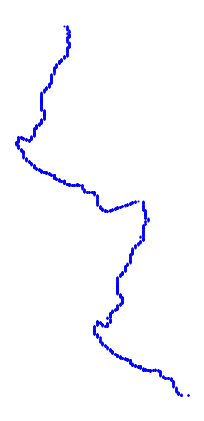

In [166]:
#location.tar.gz
import tempfile
import tarfile
import os
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
AppStartInfoR=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} START .*')
AppStopInfoR=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} STOP .*')
AppGPSInfoR=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} .* pos -> .* \[.*\] - \[.*\]')
AppGPSInfoR2=re.compile(r'\d\d\/\d\d \d\d:\d\d:\d\d.\d{3} .* pos -> .* \[.*\] - \[([\dx]*) : ([\dx]*)\]')
dirr=dir+"\\opt\\usr\\data\\location\\dump_gps.log"
time=[]
x=[]
y=[]
x_accum=[]
y_accum=[]
if 1:
    with open(dirr, 'r') as f:
        k=f.read()
        AppStartInfo=AppStartInfoR.findall(k)
        AppStopInfo=AppStopInfoR.findall(k)
        AppGPSInfo=AppGPSInfoR.findall(k)
    for i in AppStartInfo:
        print(i)
    for i in AppStopInfo:
        print(i)
    for i in AppGPSInfo:
        print(i)
        time.append(datetime.datetime.strptime(i[:18], "%m/%d %H:%M:%S.%f"))
        #[3x.4x6x0x : 1x7.x3x5x1]
        #x.append(i[-23:-15])
        #y.append(i[-20:-3])
        x.append(int(i[-16]))
        y.append(int(i[-4]))
    x_accum.append(x[0])
    y_accum.append(y[0])
    for i in range(len(x)-1):
        x_accum.append(x_accum[i])
        if (x[i+1]-(x_accum[i]%10)+10)%10<=5:
            while x_accum[i+1]%10!=x[i+1]:
                x_accum[i+1]=x_accum[i+1]+1
        else:
            while x_accum[i+1]%10!=x[i+1]:
                x_accum[i+1]=x_accum[i+1]-1
        y_accum.append(y_accum[i])
        if (y[i+1]-(y_accum[i]%10)+10)%10<=5:
            while y_accum[i+1]%10!=y[i+1]:
                y_accum[i+1]=y_accum[i+1]+1
        else:
            while y_accum[i+1]%10!=y[i+1]:
                y_accum[i+1]=y_accum[i+1]-1
    for i in range(len(y_accum)):
        y_accum[i]=y_accum[i]*10
        #print(x[i]/10, y[i], x_accum[i]/10, y_accum[i])
    plt.figure(figsize=((max(y_accum)-min(y_accum))/200,(max(x_accum)-min(x_accum))/200))
    #plt.plot(y_accum, x_accum,color='skyblue',marker='o', markerfacecolor='blue',markersize=6)
    #1틱: 대략 11.1미터, 곧 초속 50미터 이하의 범위에서는 (시속 200km 이하) 유효할 것으로 예상
    plt.axis('off')
    plt.plot(y_accum, x_accum,'bo', markersize=1)
    plt.show()
else:
    pass
        
#10월 26일 이때 기록은 없음: 덤프 시기 차이
                

In [167]:
#power/pm_reset_log
dirr=dir+"\\opt\\usr\\data\\power\\siop_reset_log"
with open(dirr, 'r') as f:
    k=f.read()
print(k)

Thu Oct 13 16:43:00 2022 RPON
Sat Oct 15 22:21:49 2022  OFF
Sat Oct 15 22:22:51 2022 RPON
Sat Oct 15 22:25:15 2022  OFF
Sat Oct 15 22:26:15 2022 NPON



In [168]:
#Smartwatch information calendar
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\usr\\home\\owner\\apps_rw\\com.samsung.w-calendar2\\data\\.calendar_consumer.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[0][0]};', con=con)
df

[('event_table',), ('sqlite_sequence',), ('reminder_table',)]


id       start         end  is_allday  is_protected summary description  \
0    1  1671969600  1671969600          1             0   크리스마스               
1    2  1672574400  1672574400          1             0      신정               
2    3  1674561600  1674561600          1             0   대체공휴일               
3    4  1696852800  1696852800          1             0     한글날               
4    5  1695988800  1695988800          1             0      추석    음력 8월15일   
5    6  1685188800  1685188800          1             0  부처님오신날    음력 4월 8일   
6    7  1674388800  1674388800          1             0      설날    음력 1월 1일   
7    8  1696334400  1696334400          1             0     개천절               
8    9  1692100800  1692100800          1             0     광복절               
9   10  1686052800  1686052800          1             0     현충일               
10  11  1683288000  1683288000          1             0    어린이날               
11  12  1677672000  1677672000          1             0     삼일절               

   location       color  uid  ... latitude longitude  temp  originalStart  \
0            215.95.100    7  ...        0         0  None  1671926400000   
1            215.95.100    1  ...        0         0  None  1672531200000   
2            215.95.100   21  ...        0         0  None  1674518400000   
3            215.95.100   11  ...        0         0  None  1696809600000   
4            215.95.100   10  ...        0         0  None  1695945600000   
5            215.95.100    9  ...        0         0  None  1685145600000   
6            215.95.100    8  ...        0         0  None  1674345600000   
7            215.95.100    6  ...        0         0  None  1696291200000   
8            215.95.100    5  ...        0         0  None  1692057600000   
9            215.95.100    4  ...        0         0  None  1686009600000   
10           215.95.100    3  ...        0         0  None  1683244800000   
11           215.95.100    2  ...        0         0  None  1677628800000   

   organizer isRepeat  editAble  deletAble isDeleted  isNeedToSync  
0      local        1         0          0         0             0  
1      local        1         0          0         0             0  
2      local        0         0          0         0             0  
3      local        1         0          0         0             0  
4      local        1         0          0         0             0  
5      local        1         0          0         0             0  
6      local        1         0          0         0             0  
7      local        1         0          0         0             0  
8      local        1         0          0         0             0  
9      local        1         0          0         0             0  
10     local        1         0          0         0             0  
11     local        1         0          0         0             0  

[12 rows x 26 columns]

In [169]:
#Smartwatch information .notification.db 센서 정보
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\dbspace\\.notification.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[0][0]};', con=con)
df

[('noti_ex_list',), ('receiver_list',), ('noti_list',), ('sqlite_sequence',), ('noti_group_data',), ('ongoing_list',), ('notification_setting',), ('notification_system_setting',), ('dnd_allow_exception',), ('noti_template',)]


Empty DataFrame
Columns: [root_id, app_id, uid, channel, priv_id, pkg_id, policy, data, insert_time, hide_list]
Index: []

In [170]:
#Smartwatch information 알람 정보
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\usr\\home\\owner\\apps_rw\\com.samsung.alarm-solis\\data\\.alarm.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[0][0]};', con=con)
df

[('alarm',), ('sqlite_sequence',), ('tone',)]


id  magic  alarm_mgr_id alarm_mgr_smart_id  enable missed author name  \
0   1      0    1308351061               None       1   None   None        

        stime       atime  ...  briefing_content_type  deviceType  uuid  \
0  1666043400  1666043400  ...                   None           2         

   mobileCreateTime  mobileModifiedTime  mobileAlertTime isDeleted  \
0                 0                   0                0         0   

   isNeedToSync contextMgrId  isOffPublicHoliDay  
0             0           -1                   1  

[1 rows x 45 columns]

In [171]:
#Smartwatch information .riminder.db 알림 정보
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\usr\\apps\\com.samsung.w-reminder\\data\\.reminder.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[0][0]};', con=con)
df

[('reminderInstance',), ('sqlite_sequence',), ('checkList',), ('imageList',), ('spaceList',)]


Empty DataFrame
Columns: [instanceId, id, title, dueTime, modTime, repeat, completedTime, isNoDueDate, data1, data2, data3, data4, alarmMgrId, alertTime, displayTime, isCompleted, uid, status, type, location, latitude, longitude, color, isAttached, isRead, isNeedToSync, isDeleted, transition, isReverse, locality, poi, locationType, geofenceId, appCardType, appCardContentIntent, appCardInfo_1, appCardInfo_2, appCardInfo_3, url, webTitle, webDescription, webThumbnailPath, colorOrder, notiTime, dismissTime, snoozeTime, weekDays, colorIndex, contextMgrId, occasionType, occasionEventType, occasionEventRepeatType, occasionName, occasionInfo1, occasionInfo2, groupId, spaceId, groupItemCreatorName, groupItemModifierName, groupItemSynced, isAllday, datesStartTime, datesEndTime, sortingTitle, rrule, duringStartTime, duringEndTime, nextAlertMgrId]
Index: []

[0 rows x 68 columns]

In [172]:
#opt\\var\\log\\appfw\\app-installers
dirr=dir+"\\opt\\var\\log\\appfw\\app-installers\\installation-history.log"
with open(dirr, 'r') as f:
    k=f.read()
print(k)

[2020-06-03 13:40:32.812 UTC][10541]pkgid:com.samsung.watchface|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:40:40.871 UTC][10577]pkgid:com.samsung.sdbd-syspopup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:40:50.953 UTC][10586]pkgid:net.wc-popup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:00.202 UTC][10600]pkgid:org.tizen.aurum-bootstrap|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:08.063 UTC][10623]pkgid:nfc-manager|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:18.102 UTC][10636]pkgid:net.wc-syspopup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:26.055 UTC][10660]pkgid:org.tizen.askuser-popup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:35.836 UTC][10724]pkgid:com.samsung.bt-syspopup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:47.521 UTC][10738]pkgid:com.samsung.w-input-selector|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:41:55.602 UTC][10752]pkgid:org.tizen.dpm-syspopup|mode:ManifestDirectInstall|SUCCESS
[2020-06-03 13:

In [173]:
#Smartwatch information .context-app-history.db 앱 사용 시간
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\usr\\home\\owner\\.applications\\dbspace\\.context-app-history.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[0][0]};', con=con)
df

[('Log_BatteryUsagePerApp',), ('Battery_LastInfo',), ('sqlite_sequence',), ('Temp_LastCpuUsagePerApp',), ('Log_AppLaunch',), ('Log_RemovableApp',), ('Temp_AppLaunchFreq',)]


AppId   StartTime     EndTime  Utime  Stime  \
0           com.samsung.timer-service  1665646984  1665646984      4      5   
1           com.samsung.alarm-service  1665647000  1665647000      0      2   
2         com.samsung.b2-setup-wizard  1665647010  1665647010    272     74   
3         com.samsung.b2-setup-wizard  1665647010  1665647030      2      0   
4                  com.samsung.w-home  1665647031  1665647031    623    170   
...                               ...         ...         ...    ...    ...   
4329    com.samsung.w-manager-service  1666165095  1666165696      6      4   
4330                  com.samsung.scs  1666165095  1666165696      0      1   
4331           com.samsung.windicator  1666165096  1666165696     11      6   
4332            com.samsung.watchface  1666165096  1666165696      2      0   
4333  com.samsung.health-data-service  1666165096  1666165696      1      0   

      TotalTime  
0             9  
1             2  
2           346  
3             2  
4           793  
...         ...  
4329         10  
4330          1  
4331         17  
4332          2  
4333          1  

[4334 rows x 6 columns]

[('HISTORY',), ('sqlite_sequence',)]
        ID EVENT_NAME           DELTA_TIME BATTERY CHARGING  \
0        1        wro  221013 16:43:26.474      95      (-)   
1        2       susp  221013 16:43:30.061      95      (-)   
2        3        dsp  221013 16:43:30.092      95      (-)   
3        4        app  221013 16:43:30.659      95      (-)   
4        5       wkup  221013 16:43:50.030      94      (-)   
...    ...        ...                  ...     ...      ...   
5334  5335        app  221019 15:14:23.797      91      (-)   
5335  5336        app  221019 15:14:23.831      91      (-)   
5336  5337        app  221019 15:14:44.205      91      (-)   
5337  5338        app  221019 15:14:44.278      91      (-)   
5338  5339        wro  221019 15:17:07.199      90      (-)   

                            DESC0 DESC1  
0                               +        
1                                        
2                               -        
3     com.samsung.b2-setup-wizard    b

C:\Users\Post G\AppData\Local\Temp\ipykernel_11540\615873227.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['TIME']=df2['DELTA_TIME'].apply(lambda x: datetime.datetime.strptime(x, "%y%m%d %H:%M:%S.%f"))


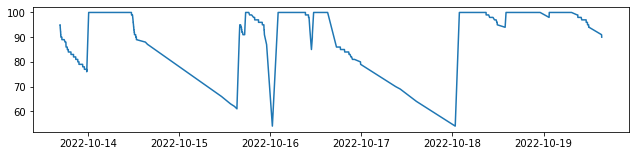

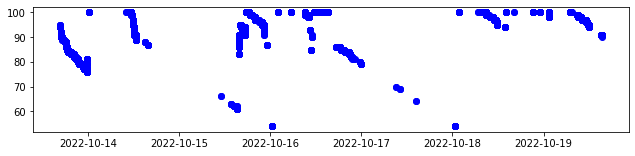

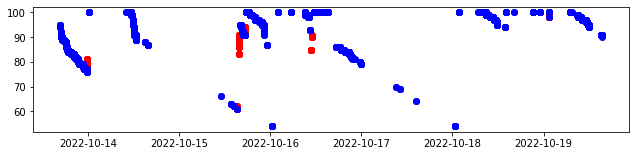

 54


In [174]:
#Smartwatch information .context-app-history.db 앱 사용 시간
import sqlite3
import pandas as pd
dirr=dir+"\\opt\\usr\\home\\owner\\apps_rw\\com.samsung.power-monitor-service\\data\\batterystat221013164320.db"
con=sqlite3.connect(dirr)
cur=con.cursor()
cur.execute('select name from sqlite_master where type="table";')
tablename=cur.fetchall()
print(tablename)
df=pd.read_sql(f'select * from {tablename[0][0]};', con=con)
print(df)
df2=df[df['BATTERY'].apply(int)>=0]
plt.figure(figsize=(df2.shape[0]/500,(max(df2['BATTERY'].apply(int))-min(df2['BATTERY'].apply(int)))/20))
plt.axis('auto')
df2['TIME']=df2['DELTA_TIME'].apply(lambda x: datetime.datetime.strptime(x, "%y%m%d %H:%M:%S.%f"))
plt.plot(df2['TIME'], df2['BATTERY'].apply(int))
plt.show()
plt.figure(figsize=(df2.shape[0]/500,(max(df2['BATTERY'].apply(int))-min(df2['BATTERY'].apply(int)))/20))
plt.axis('auto')
plt.plot(df2['TIME'], df2['BATTERY'].apply(int), 'bo')
plt.show()

plt.figure(figsize=(df2.shape[0]/500,(max(df2['BATTERY'].apply(int))-min(df2['BATTERY'].apply(int)))/20))
plt.axis('auto')
dfplus=df2[df2['CHARGING']=="(+)"]
dfminus=df2[df2['CHARGING']=="(-)"]
plt.plot(dfplus['TIME'], dfplus['BATTERY'].apply(int), 'ro')
plt.plot(dfminus['TIME'], dfminus['BATTERY'].apply(int), 'bo')
plt.show()
print(df2['BATTERY'].min())